- Full Name: **`MohammadParsa Dini`**
- Student ID: **`400101204`**

# 🧠 Homework 4: Vision Transformer (ViT)

## 📌 Objective
In this assignment, you will **implement a Vision Transformer (ViT) from scratch** and gain a deep understanding of its core components. You will:

- 🛠️ Complete all core blocks of the Vision Transformer model.
- 🧪 Train the ViT on the CIFAR-10 image classification dataset.
- 👁️ Visualize attention maps to interpret model behavior.
- 📊 Analyze the effect of hyperparameters (e.g., patch size, depth, heads) on model performance.

---

## 📚 Learning Goals
By the end of this assignment, you should be able to:
- Explain the role of patch embeddings, self-attention, and MLP layers in ViT.
- Implement Transformer blocks without relying on high-level libraries like Hugging Face Transformers.
- Visualize self-attention maps to understand how ViT focuses on different parts of an image.
- Experiment with architectural design choices and evaluate their effects.

---

## 🧪 Dataset
We will use the **CIFAR-10** dataset, which consists of 60,000 32×32 color images in 10 classes, with 6,000 images per class. The dataset is split into 50,000 training and 10,000 test images.

---

## 🎯 Evaluation Criteria

Your final submission will be evaluated based on:
- ✅ Correct implementation of all model components.
- ✅ Accuracy of the model on CIFAR-10 test set.
- ✅ Insightfulness of attention visualizations.
- ✅ Clarity of code and documentation.
- ✅ Quality of hyperparameter analysis and discussion.





In [12]:
# ===============================
# 1.1 Setup & Imports
# ===============================
!pip install einops torch torchvision matplotlib seaborn --quiet

In [13]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device)


Using cuda


In [14]:
import torchvision.datasets as datasets
# ===============================
# 1.2 Data Loading & Visualization
# ===============================
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

## To Do: Load CIFAR10:
train_ds = datasets.CIFAR10(root='./train',train=True,download=True, transform=transform)
test_ds = datasets.CIFAR10(root='./test',train=False,download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=False)


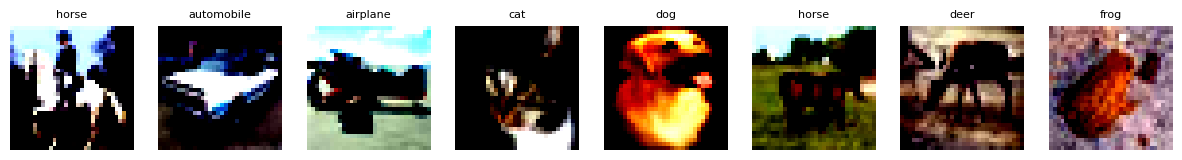

In [15]:
import matplotlib.pyplot as plt

## TO do: Visualize 8 images with their labels
classes = train_ds.classes
images, labels = next(iter(train_loader))
fig, axes = plt.subplots(1, 8, figsize=(15, 2))
for i in range(8):
    img = images[i].permute(1, 2, 0).numpy()  # Convert to [H, W, C]
    label = classes[labels[i]]
    axes[i].imshow(img)
    axes[i].set_title(f"{label}", fontsize=8)
    axes[i].axis('off')
plt.show()


In [16]:
# ===============================
# 1.3 Helper: pair
# ===============================
def pair(t):
    return t if isinstance(t, tuple) else (t, t)


In [17]:
# ===============================
# 1.4 FeedForward
# ===============================
## To Do: Complete the FeedForward module -> layer norm -> Linear -> GELU -> Dropout -> Linear -> Dropout
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)


In [18]:

# ===============================
# 1.5 Attention
# ===============================
## ToDo: Complete the Attention module
class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = heads * dim_head
        self.heads = heads
        self.scale = dim_head ** -0.5
        ## layer norm
        self.norm = nn.LayerNorm(dim)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        ## softmax
        self.attend = nn.Softmax(dim=-1)
        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x = self.norm(x)
        q, k, v = self.to_qkv(x).chunk(3, dim=-1)
        q = rearrange(q, 'b n (h d) -> b h n d', h=self.heads)
        k = rearrange(k, 'b n (h d) -> b h n d', h=self.heads)
        v = rearrange(v, 'b n (h d) -> b h n d', h=self.heads)

        ## q, k multiplication
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        ## softmax
        attn = self.attend(dots)
        ### dropout
        attn = self.dropout(attn)
        ## v multiplication
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)


In [19]:

# ===============================
# 1.6 Transformer Block
# ===============================
## To Do: Complete the Transformer module
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([
            ## Attention + FeedForward
            nn.ModuleList([
                Attention(dim, heads=heads, dim_head=dim_head, dropout=dropout),
                FeedForward(dim, hidden_dim=mlp_dim, dropout=dropout)
            ]) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        for attn, ff in self.layers:
            ## To do: Normal Transformer forward, nothing weird
            x = attn(x) + x     # Residual connection after attention
            x = ff(x) + x       # Residual connection after feedforward
        return self.norm(x)


In [24]:

# ===============================
# 1.7 ViT Model
# ===============================
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes,
                 dim, depth, heads, mlp_dim,
                 pool='cls', channels=3,
                 dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
                      p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, dim)
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    ## To do: complete the forward function
    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :x.size(1)]                # Add positional encoding
        x = self.dropout(x)

        x = self.transformer(x)                               # [b, n+1, dim]

        x = x[:, 0] if self.pool == 'cls' else x.mean(dim=1)  # Pooling
        return self.mlp_head(x)                               # Classification head


In [23]:

# ===============================
# 1.8 Training Loop & Visualization
# ===============================
## To do: Complete the training loop
def train(model, epochs=10, lr=3e-4):
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    model.to(device)
    losses = []
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            ## Forward, loss and backward here
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, labels)

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss+= loss.item()

        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    # Evaluate
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"Test Accuracy: {100 * correct / total:.2f}%")



Epoch 1/20, Loss: 1.6439
Epoch 2/20, Loss: 1.3313
Epoch 3/20, Loss: 1.2049
Epoch 4/20, Loss: 1.1229
Epoch 5/20, Loss: 1.0629
Epoch 6/20, Loss: 1.0066
Epoch 7/20, Loss: 0.9615
Epoch 8/20, Loss: 0.9151
Epoch 9/20, Loss: 0.8725
Epoch 10/20, Loss: 0.8388
Epoch 11/20, Loss: 0.8002
Epoch 12/20, Loss: 0.7634
Epoch 13/20, Loss: 0.7318
Epoch 14/20, Loss: 0.7022
Epoch 15/20, Loss: 0.6712
Epoch 16/20, Loss: 0.6417
Epoch 17/20, Loss: 0.6108
Epoch 18/20, Loss: 0.5903
Epoch 19/20, Loss: 0.5655
Epoch 20/20, Loss: 0.5385


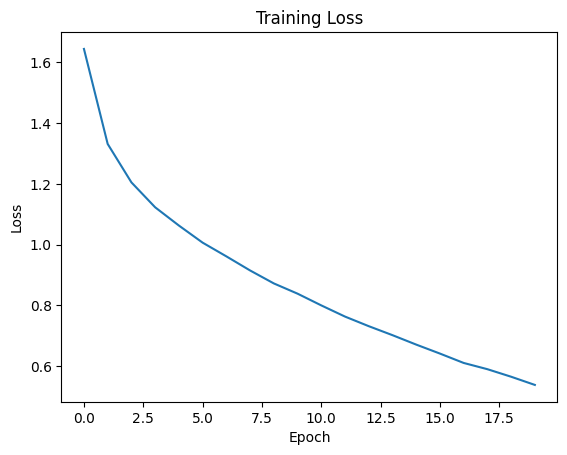

Test Accuracy: 66.54%


In [11]:

# ===============================
# Run and enjoy!
# ===============================
model = ViT(
    image_size=32, patch_size=4, num_classes=10,
    dim=128, depth=6, heads=8, mlp_dim=256,
    pool='cls', channels=3, dim_head=64,
    dropout=0.1, emb_dropout=0.1
)

train(model, epochs=20)


---

## 🧠 Bonus (Optional)
- 🧩 Implement a variant of ViT using sinusoidal positional embeddings.
- 🎨 Visualize per-head attention maps across different layers.
- 🔁 Try training with different patch sizes and analyze effects.

---

## Patch Size =2
the patch size was decreased from 4 to 2, while the other parmas of model remained unchanged like number of heads in attn structure(`heads`),depth of the layers(`depth`) and `dim_head`:

In [ ]:
model2 = ViT(
    image_size=32, patch_size=2, num_classes=10,
    dim=128, depth=6, heads=8, mlp_dim=256,
    pool='cls', channels=3, dim_head=64,
    dropout=0.1, emb_dropout=0.1
)

train(model2, epochs=20)

Epoch 1/20, Loss: 1.6948
Epoch 2/20, Loss: 1.3586
Epoch 3/20, Loss: 1.2293
Epoch 4/20, Loss: 1.1448
Epoch 5/20, Loss: 1.0705
Epoch 6/20, Loss: 1.0110
Epoch 7/20, Loss: 0.9505
Epoch 8/20, Loss: 0.9086
Epoch 9/20, Loss: 0.8613
Epoch 10/20, Loss: 0.8220
Epoch 11/20, Loss: 0.7775


## Sinusoidal Positional Embedding VIT
We can see that using sinusoidal positiona embeddings we elevated the accuracy from 64% to 70%

Epoch 1/20, Loss: 1.5860
Epoch 2/20, Loss: 1.2462
Epoch 3/20, Loss: 1.1055
Epoch 4/20, Loss: 1.0158
Epoch 5/20, Loss: 0.9487
Epoch 6/20, Loss: 0.8906
Epoch 7/20, Loss: 0.8442
Epoch 8/20, Loss: 0.7964
Epoch 9/20, Loss: 0.7519
Epoch 10/20, Loss: 0.7115
Epoch 11/20, Loss: 0.6721
Epoch 12/20, Loss: 0.6336
Epoch 13/20, Loss: 0.5998
Epoch 14/20, Loss: 0.5643
Epoch 15/20, Loss: 0.5293
Epoch 16/20, Loss: 0.4952
Epoch 17/20, Loss: 0.4670
Epoch 18/20, Loss: 0.4341
Epoch 19/20, Loss: 0.4109
Epoch 20/20, Loss: 0.3912


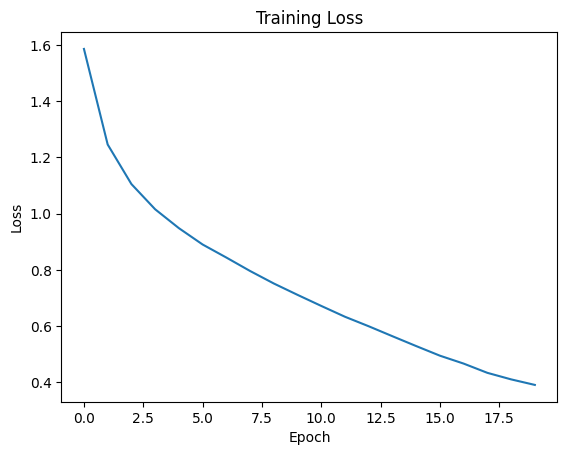

Test Accuracy: 70.50%


In [27]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
import matplotlib.pyplot as plt

# === Utility ===
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

def get_sinusoidal_positional_embedding(seq_len, dim, device):
    pe = torch.zeros(seq_len, dim, device=device)
    position = torch.arange(0, seq_len, dtype=torch.float, device=device).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, dim, 2, device=device).float() * (-math.log(10000.0) / dim))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.unsqueeze(0)

# === Modules ===
class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.):
        super().__init__()
        inner_dim = heads * dim_head
        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.to_out = nn.Linear(inner_dim, dim)

    def forward(self, x, return_attn=False):
        x = self.norm(x)
        q, k, v = self.to_qkv(x).chunk(3, dim=-1)
        q = rearrange(q, 'b n (h d) -> b h n d', h=self.heads)
        k = rearrange(k, 'b n (h d) -> b h n d', h=self.heads)
        v = rearrange(v, 'b n (h d) -> b h n d', h=self.heads)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = torch.softmax(dots, dim=-1)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        if return_attn:
            return self.to_out(out), attn
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout=0.):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.ModuleList([
                Attention(dim, heads, dim_head, dropout),
                FeedForward(dim, mlp_dim, dropout)
            ]) for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

class ViT_Sin(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes,
                 dim, depth, heads, mlp_dim,
                 pool='cls', channels=3,
                 dim_head=64, dropout=0., emb_dropout=0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
                      p1=patch_height, p2=patch_width),
            nn.Linear(patch_dim, dim)
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        """
        HERE IS THE SINUSOIDAL POSITIONAL EMBEDDINGS
        """
        self.pos_embedding = get_sinusoidal_positional_embedding(num_patches + 1, dim, device='cpu')
        self.pos_embedding.requires_grad = False

        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)
        self.pool = pool
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embedding[:, :x.size(1)].to(x.device)
        x = self.dropout(x)

        x = self.transformer(x)

        x = x[:, 0] if self.pool == 'cls' else x.mean(dim=1)
        return self.mlp_head(x)

# === Visualization ===
def visualize_attention(model, image_tensor, layer_idx=0, head_idx=0):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(next(model.parameters()).device)
    with torch.no_grad():
        x = model.to_patch_embedding(image_tensor)
        b, n, _ = x.shape
        cls_tokens = repeat(model.cls_token, '1 1 d -> b 1 d', b=b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += model.pos_embedding[:, :x.size(1)].to(x.device)
        x = model.dropout(x)

        for i, (attn_layer, ff) in enumerate(model.transformer.layers):
            if i == layer_idx:
                x = attn_layer.norm(x)
                q, k, v = attn_layer.to_qkv(x).chunk(3, dim=-1)
                q = rearrange(q, 'b n (h d) -> b h n d', h=attn_layer.heads)
                k = rearrange(k, 'b n (h d) -> b h n d', h=attn_layer.heads)
                dots = torch.matmul(q, k.transpose(-1, -2)) * attn_layer.scale
                attn = torch.softmax(dots, dim=-1)

                cls_attn = attn[0, head_idx, 0, 1:].reshape(4, 4).cpu()
                plt.imshow(cls_attn, cmap='viridis')
                plt.title(f"Layer {i}, Head {head_idx} Attention")
                plt.colorbar()
                plt.show()
                break
            else:
                x = attn_layer(x) + x
                x = ff(x) + x




# ===============================
# Run and enjoy!
# ===============================
model = ViT_Sin(
    image_size=32, patch_size=4, num_classes=10,
    dim=128, depth=6, heads=8, mlp_dim=256,
    pool='cls', channels=3, dim_head=64,
    dropout=0.1, emb_dropout=0.1
)

train(model, epochs=20)

In [ ]:
visualize_attention